# Libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
from scripts.fedAvg import FedAvg
import matplotlib.pyplot as plt

import re
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from prettytable import PrettyTable

# Constants

In [4]:
RESULT_PATH = './results/'
MODELS_PATH = './models/'
ALZ_TEST_PATH = './Alzheimer/test'
TUM_TEST_PATH = './Brain_Tumor/test'
WIDTH = 176
HEIGHT = 208
BATCH_SIZE = 32
ALZ_LABELS = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
TUM_LABELS = ["glioma", "meningioma", "notumor", "pituitary"]

## Plotting training losses
The title of each plot represent:
<ul>
<li> Num_round
<li> Epochs
<li> Number of devices
</ul>

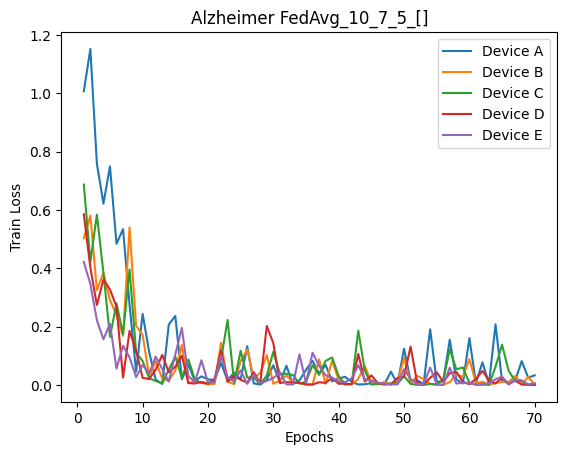

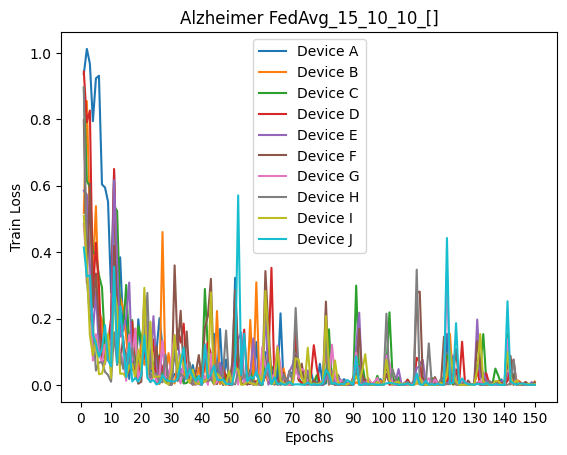

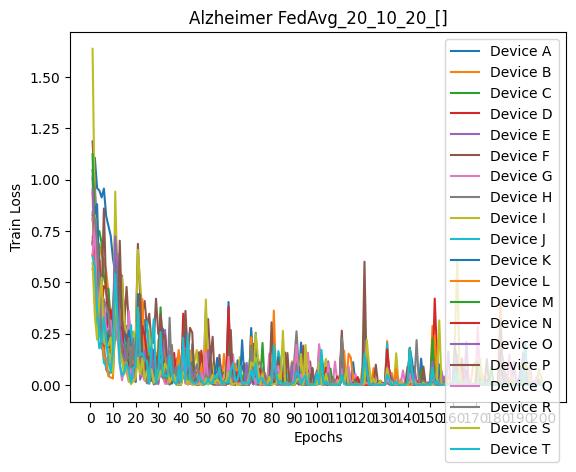

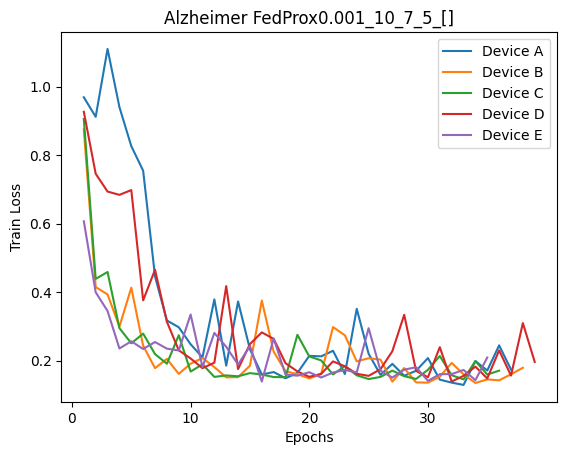

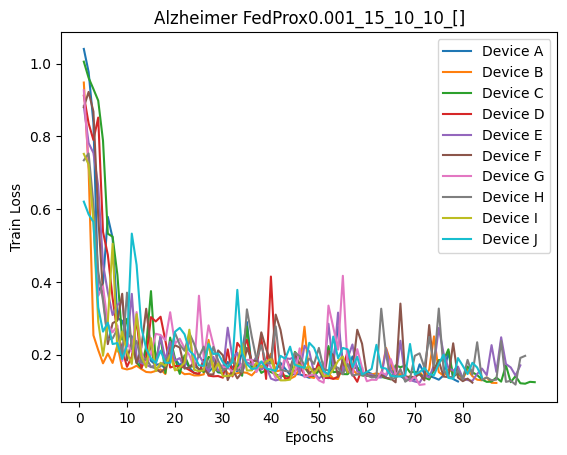

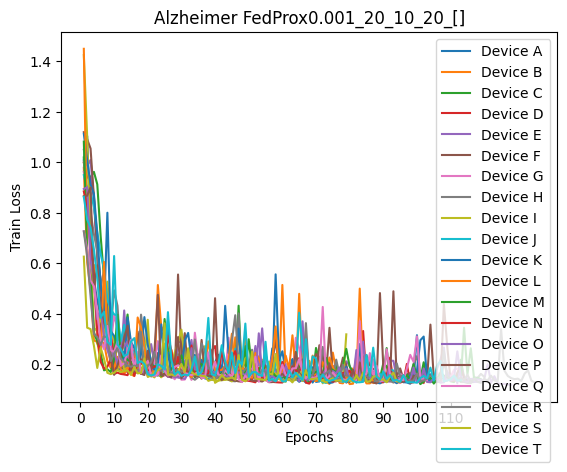

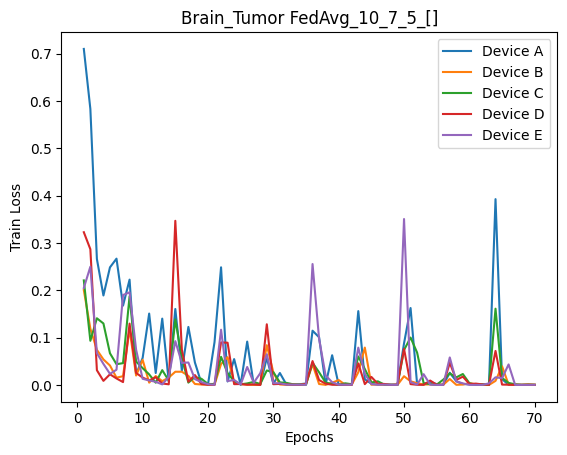

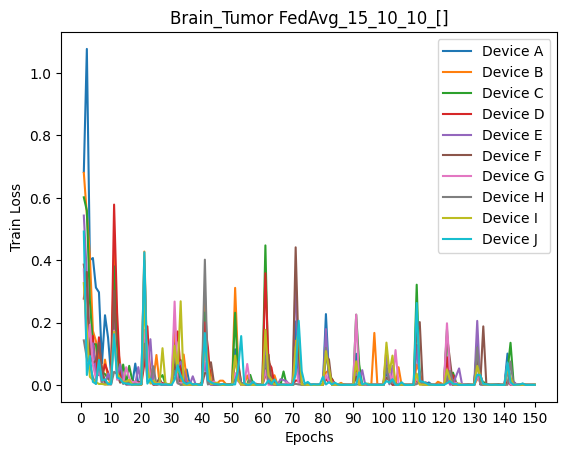

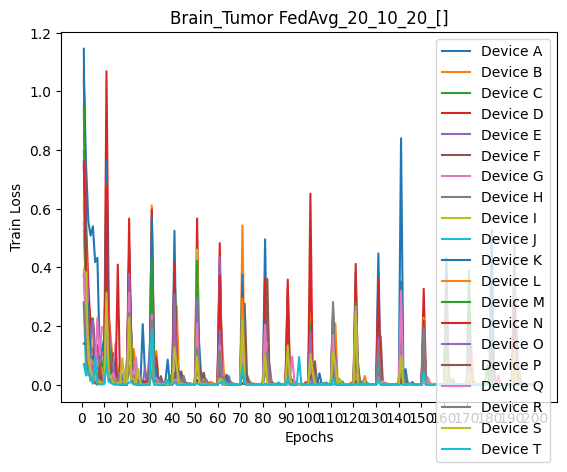

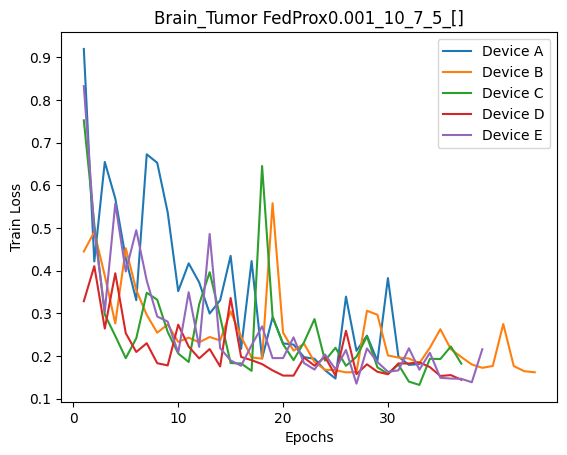

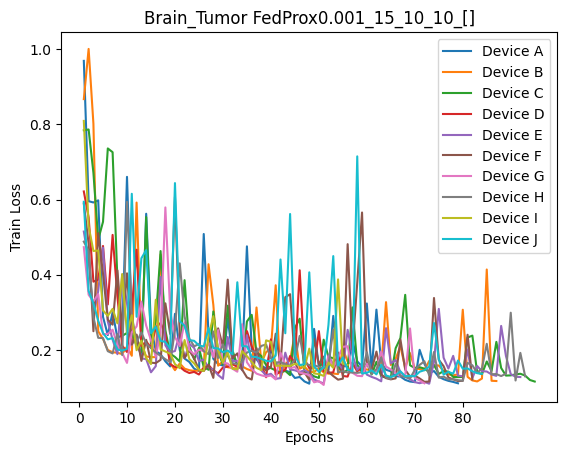

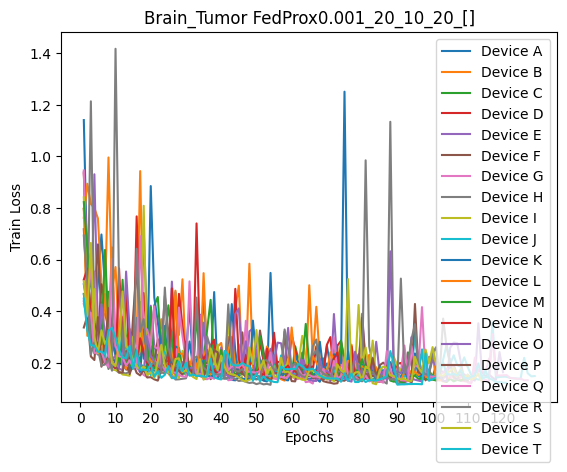

In [5]:
def create_dictionary(json_data):
    output = {}
    out_of_battery = []
    for key in json_data.keys():
        epoch_loss = []
        for round,dict_loss in json_data[key].items():
            if dict_loss == "out_of_battery":
                out_of_battery.append(key)
                losses = []
            else:
                losses = [float(ep[0]) for ep in dict_loss.values()]
            #print(losses)
            epoch_loss += losses
        output[key] = epoch_loss

    return output, set(out_of_battery)


for dir in os.listdir(RESULT_PATH):
  for data_file in sorted(os.listdir(os.path.join(RESULT_PATH,dir))):
    if data_file.endswith('.json'):
        path = os.path.join(RESULT_PATH,dir,data_file)
        with open(path, 'r') as file:
          data = json.load(file)

        pattern = re.compile(r'')
        title = re.sub(pattern, lambda match: match.group(0).replace('_', ''), data_file)
        output, out_of_battery = create_dictionary(data)
        # Flatten the JSON data

        max_length = max(len(values) for values in output.values())

        # Define your list of integer values for the x-axis
        x_values = (range(1, max_length + 1))
        for key, values in output.items():
            x_values = (range(1, len(values) + 1))
            plt.plot(x_values, values, label=f"Device {key}")
            if key in out_of_battery:
                plt.scatter(x_values[-1], values[-1], label=f"Device {key} out of battery", marker='o', color='red',s=70)

        # Adding labels and legend
        plt.title(dir + ' ' + data_file.removesuffix('.json'))
        plt.xlabel('Epochs')
        plt.ylabel('Train Loss')
        plt.legend()

        plt.xticks([0] + [x for x in x_values[1:] if x % 10 == 0])
        # Show the plot
        plt.show()


# Evaluation of models on test set

## Load test set

In [35]:
def preprocess_data(image, label):
    label = tf.one_hot(label, depth=4)
    return image, label


alz_test_set = tf.keras.preprocessing.image_dataset_from_directory(
      ALZ_TEST_PATH,
      seed=42,
      image_size=(WIDTH,HEIGHT),
      batch_size=BATCH_SIZE,
      class_names = ALZ_LABELS,
      color_mode='grayscale',
      shuffle = False
      )

tum_test_set = tf.keras.preprocessing.image_dataset_from_directory(
      TUM_TEST_PATH,
      seed=42,
      image_size=(WIDTH,HEIGHT),
      batch_size=BATCH_SIZE,
      class_names = TUM_LABELS,
      color_mode='grayscale',
      shuffle = False
      )

alz_test_set = alz_test_set.map(preprocess_data)
tum_test_set = tum_test_set.map(preprocess_data)

Found 1025 files belonging to 4 classes.
Found 1281 files belonging to 4 classes.


## Alzheimer Evaluation

Predicting...
33/33 [==============================] - 4s 94ms/step
Done !

Aggregation: FedAvg  Num_rounds: 10 Num_epochs: 7 N_Devices: 5 OOB:[]
                  precision    recall  f1-score   support

     NonDemented       0.97      0.98      0.97       512
VeryMildDemented       0.98      0.96      0.97       359
    MildDemented       0.95      0.97      0.96       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.97      1025
       macro avg       0.97      0.97      0.97      1025
    weighted avg       0.97      0.97      0.97      1025


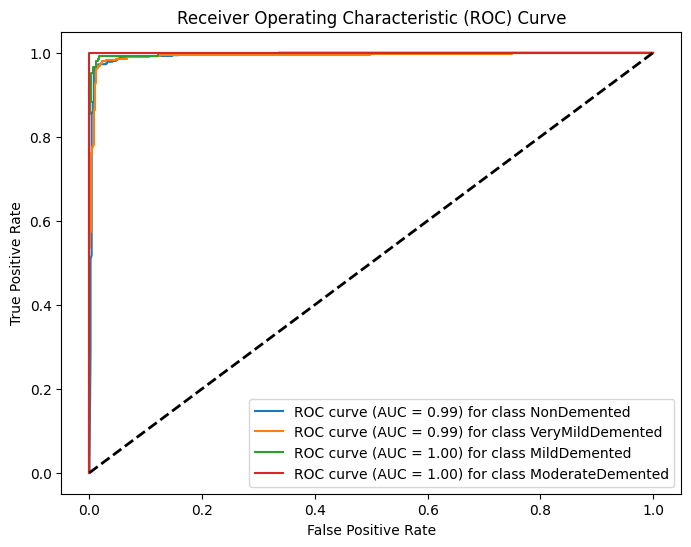


****************************************************************************************************
Predicting...
33/33 [==============================] - 4s 94ms/step
Done !

Aggregation: FedAvg  Num_rounds: 15 Num_epochs: 10 N_Devices: 10 OOB:[]
                  precision    recall  f1-score   support

     NonDemented       0.95      0.98      0.97       512
VeryMildDemented       0.98      0.92      0.95       359
    MildDemented       0.99      0.99      0.99       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.96      1025
       macro avg       0.98      0.97      0.98      1025
    weighted avg       0.96      0.96      0.96      1025


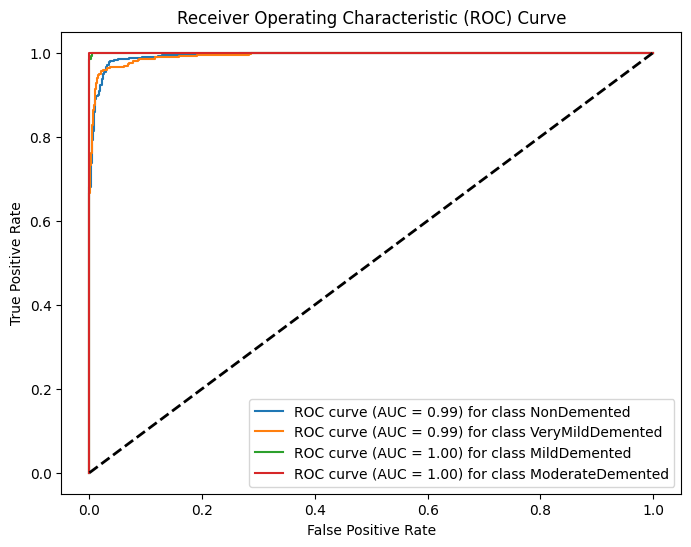


****************************************************************************************************
Predicting...
33/33 [==============================] - 4s 97ms/step
Done !

Aggregation: FedAvg  Num_rounds: 20 Num_epochs: 10 N_Devices: 20 OOB:[]
                  precision    recall  f1-score   support

     NonDemented       0.88      0.98      0.93       512
VeryMildDemented       0.97      0.84      0.90       359
    MildDemented       0.97      0.90      0.93       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.92      1025
       macro avg       0.96      0.93      0.94      1025
    weighted avg       0.93      0.92      0.92      1025


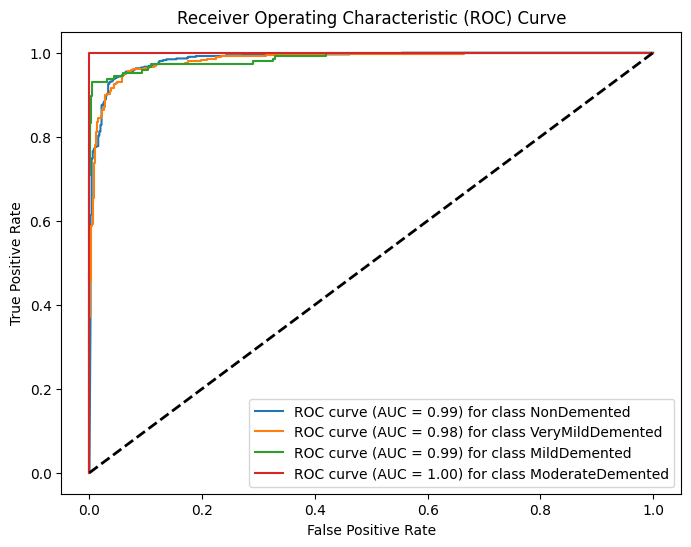


****************************************************************************************************
Predicting...
33/33 [==============================] - 4s 93ms/step
Done !

Aggregation: FedProx0.001  Num_rounds: 10 Num_epochs: 7 N_Devices: 5 OOB:[]
                  precision    recall  f1-score   support

     NonDemented       0.99      0.96      0.98       512
VeryMildDemented       0.96      0.96      0.96       359
    MildDemented       0.92      0.99      0.96       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.97      1025
       macro avg       0.97      0.98      0.97      1025
    weighted avg       0.97      0.97      0.97      1025


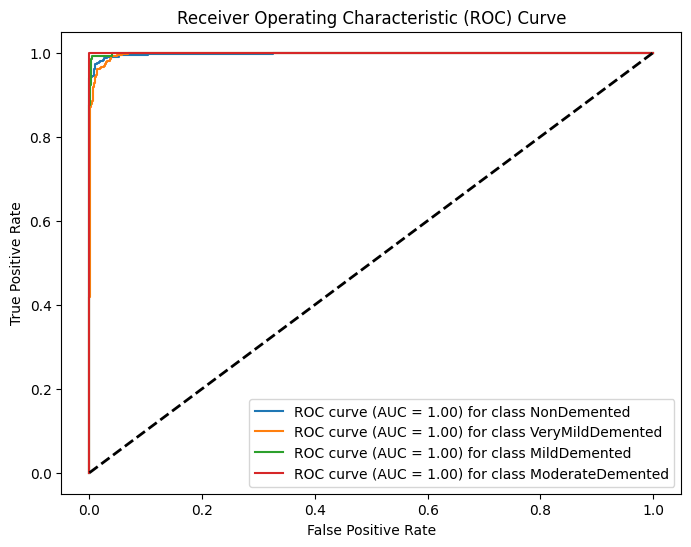


****************************************************************************************************
Predicting...
33/33 [==============================] - 4s 92ms/step
Done !

Aggregation: FedProx0.001  Num_rounds: 15 Num_epochs: 10 N_Devices: 10 OOB:[]
                  precision    recall  f1-score   support

     NonDemented       0.98      0.98      0.98       512
VeryMildDemented       0.96      0.97      0.97       359
    MildDemented       0.99      0.99      0.99       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.98      1025
       macro avg       0.98      0.98      0.98      1025
    weighted avg       0.98      0.98      0.98      1025


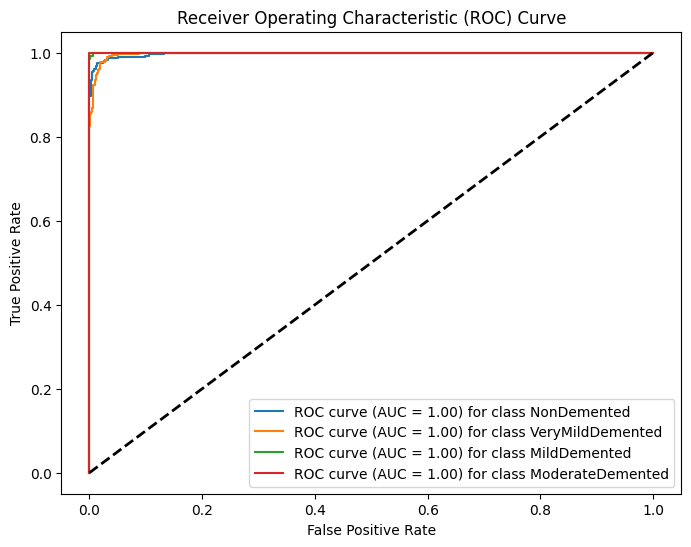


****************************************************************************************************
Predicting...
33/33 [==============================] - 4s 93ms/step
Done !

Aggregation: FedProx0.001  Num_rounds: 20 Num_epochs: 10 N_Devices: 20 OOB:[]
                  precision    recall  f1-score   support

     NonDemented       0.94      0.98      0.96       512
VeryMildDemented       0.97      0.94      0.95       359
    MildDemented       1.00      0.91      0.95       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.96      1025
       macro avg       0.98      0.96      0.97      1025
    weighted avg       0.96      0.96      0.96      1025


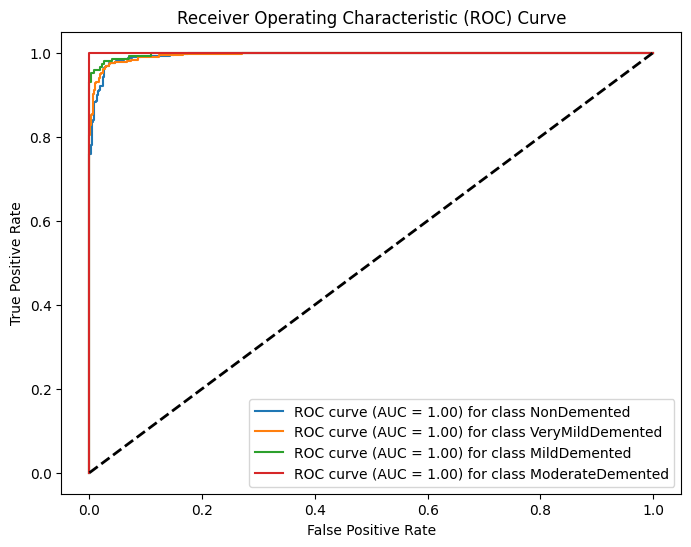


****************************************************************************************************


In [42]:
y_true  = list(alz_test_set.unbatch().map(lambda x, y: (tf.argmax(y))).as_numpy_iterator())
alz_result = {}
for experiment_model in os.listdir(os.path.join(MODELS_PATH,"Alzheimer")):
    
    parts = experiment_model.split('_')

    # Extract values from the split parts
    aggregation = parts[0]
    num_rounds = parts[1]
    num_epochs = parts[2]
    n_devices = parts[3]
    oob = parts[4]
    formatted_string = f'Aggregation: {aggregation}  Num_rounds: {num_rounds} Num_epochs: {num_epochs} N_Devices: {n_devices} OOB:{oob}'
    
    #create model 
    model = FedAvg()    
    
    #load weights
    model.load_weights(MODELS_PATH + "Alzheimer/" + experiment_model + "/").expect_partial()
    
    #predictions 
    print('Predicting...')
    logits = model.predict(alz_test_set.map(lambda x, y: x))
    y_predicted = list((map(np.argmax, logits)))
    print('Done !')
    print()
    
    alz_result[experiment_model] = classification_report(
            y_true,
            y_predicted,
            target_names=ALZ_LABELS,
            zero_division=False,
            output_dict=True
            )
    
    #print classification report
    print(formatted_string)
    print(
        classification_report(
            y_true,
            y_predicted,
            target_names=ALZ_LABELS,
            zero_division=False
            )
        )
        
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    tresh = dict()

    for i,class_name in enumerate(ALZ_LABELS):
        fpr[class_name], tpr[class_name], tresh[class_name] = roc_curve(y_true_bin[:, i], logits[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for el in ALZ_LABELS:
        plt.plot(fpr[el], tpr[el], label=f'ROC curve (AUC = {roc_auc[el]:.2f}) for class {el}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print()
    print("*"*100)


## Brain Tumor Evaluation

Predicting...
41/41 [==============================] - 4s 94ms/step
Done !

Aggregation: FedAvg  Num_rounds: 10 Num_epochs: 7 N_Devices: 5 OOB:[]
              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       299
  meningioma       0.89      0.95      0.92       301
     notumor       0.98      0.99      0.99       381
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1281
   macro avg       0.96      0.96      0.96      1281
weighted avg       0.96      0.96      0.96      1281


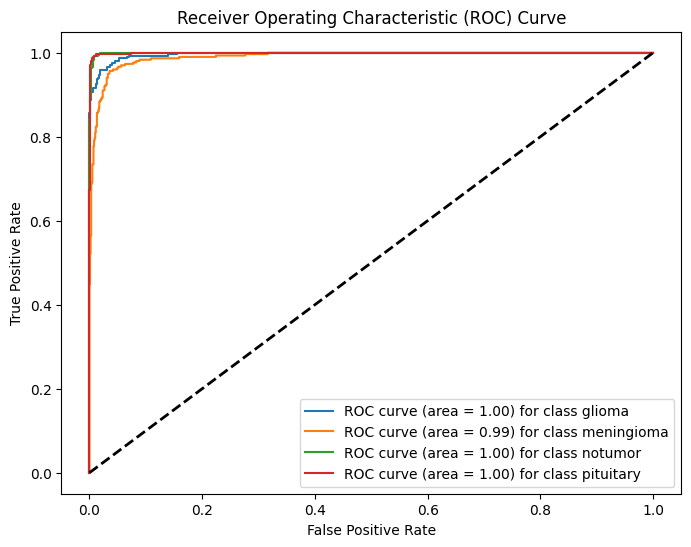


****************************************************************************************************
Predicting...
41/41 [==============================] - 6s 102ms/step
Done !

Aggregation: FedAvg  Num_rounds: 15 Num_epochs: 10 N_Devices: 10 OOB:[]
              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       299
  meningioma       0.85      0.94      0.90       301
     notumor       0.98      0.98      0.98       381
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1281
   macro avg       0.95      0.94      0.94      1281
weighted avg       0.95      0.95      0.95      1281


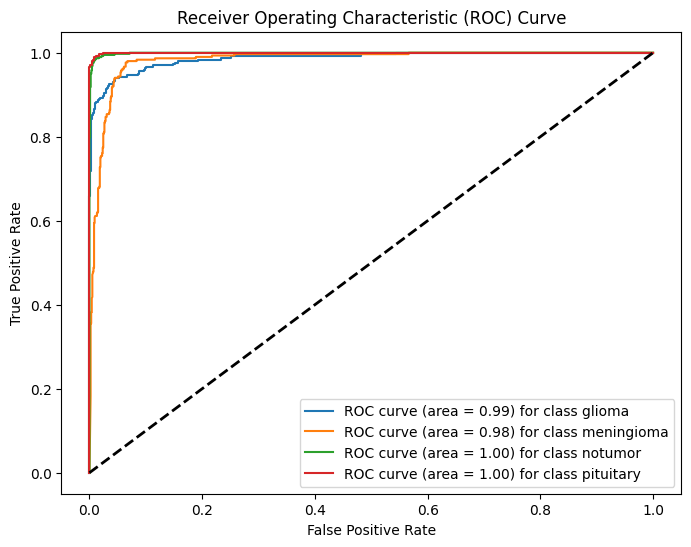


****************************************************************************************************
Predicting...
41/41 [==============================] - 5s 98ms/step
Done !

Aggregation: FedAvg  Num_rounds: 20 Num_epochs: 10 N_Devices: 20 OOB:[]
              precision    recall  f1-score   support

      glioma       0.95      0.90      0.92       299
  meningioma       0.88      0.91      0.90       301
     notumor       0.98      0.96      0.97       381
   pituitary       0.94      0.99      0.96       300

    accuracy                           0.94      1281
   macro avg       0.94      0.94      0.94      1281
weighted avg       0.94      0.94      0.94      1281


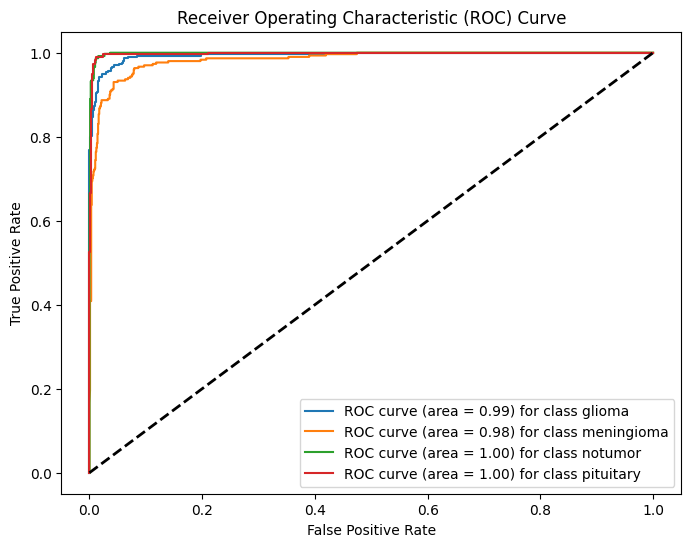


****************************************************************************************************
Predicting...
41/41 [==============================] - 4s 95ms/step
Done !

Aggregation: FedProx0.001  Num_rounds: 10 Num_epochs: 7 N_Devices: 5 OOB:[]
              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       299
  meningioma       0.92      0.90      0.91       301
     notumor       0.98      0.99      0.98       381
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1281
   macro avg       0.95      0.95      0.95      1281
weighted avg       0.96      0.96      0.96      1281


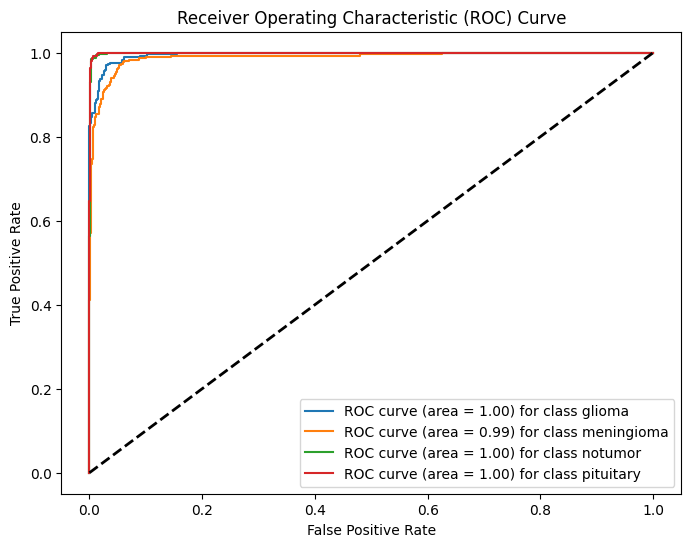


****************************************************************************************************
Predicting...
41/41 [==============================] - 4s 90ms/step
Done !

Aggregation: FedProx0.001  Num_rounds: 15 Num_epochs: 10 N_Devices: 10 OOB:[]
              precision    recall  f1-score   support

      glioma       0.98      0.81      0.88       299
  meningioma       0.84      0.93      0.88       301
     notumor       0.98      0.98      0.98       381
   pituitary       0.95      1.00      0.97       300

    accuracy                           0.93      1281
   macro avg       0.94      0.93      0.93      1281
weighted avg       0.94      0.93      0.93      1281


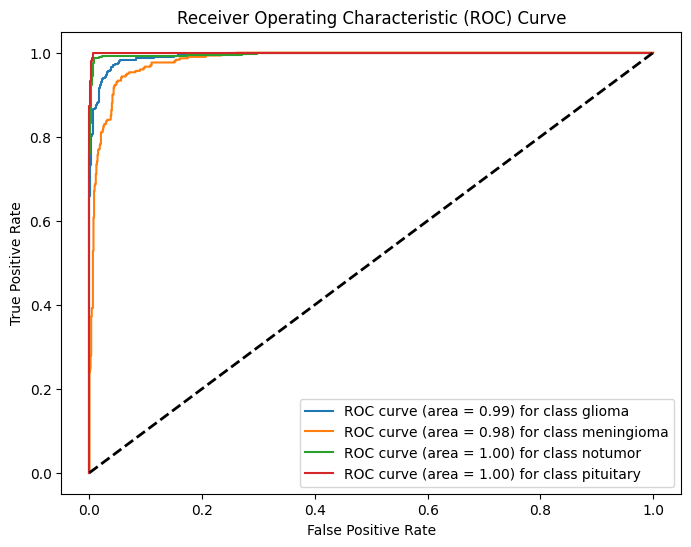


****************************************************************************************************
Predicting...
41/41 [==============================] - 5s 98ms/step
Done !

Aggregation: FedProx0.001  Num_rounds: 20 Num_epochs: 10 N_Devices: 20 OOB:[]
              precision    recall  f1-score   support

      glioma       0.90      0.93      0.92       299
  meningioma       0.92      0.87      0.89       301
     notumor       0.98      0.99      0.98       381
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.95      1281
   macro avg       0.94      0.94      0.94      1281
weighted avg       0.95      0.95      0.95      1281


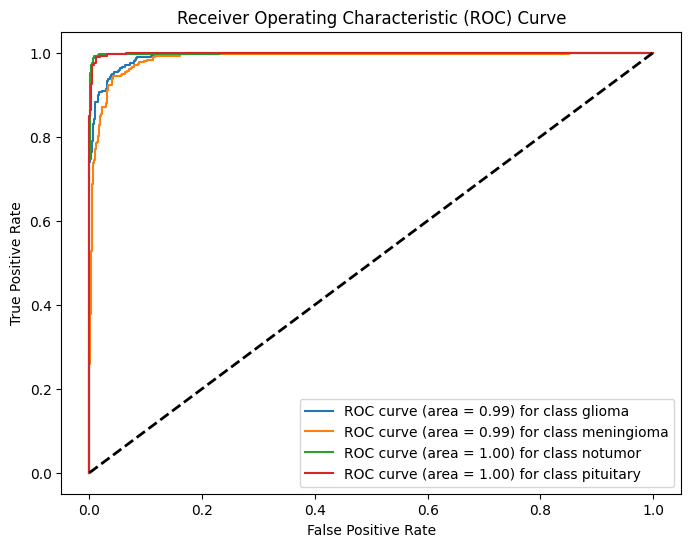


****************************************************************************************************


In [43]:
y_true  = list(tum_test_set.unbatch().map(lambda x, y: (tf.argmax(y))).as_numpy_iterator())
tum_result = {}
for experiment_model in os.listdir(os.path.join(MODELS_PATH,"Brain_Tumor")):
    
    parts = experiment_model.split('_')

    # Extract values from the split parts
    aggregation = parts[0]
    num_rounds = parts[1]
    num_epochs = parts[2]
    n_devices = parts[3]
    oob = parts[4]
    formatted_string = f'Aggregation: {aggregation}  Num_rounds: {num_rounds} Num_epochs: {num_epochs} N_Devices: {n_devices} OOB:{oob}'
    
    #create model 
    model = FedAvg()    
    
    #load weights
    model.load_weights(MODELS_PATH + "Brain_Tumor/" + experiment_model + "/").expect_partial()
    
    #predictions 
    print('Predicting...')
    logits = model.predict(tum_test_set.map(lambda x, y: x))
    y_predicted = list((map(np.argmax, logits)))
    print('Done !')
    print()
    tum_result[experiment_model] = classification_report(
            y_true,
            y_predicted,
            target_names=TUM_LABELS,
            zero_division=False,
            output_dict=True
            )
    #print classification report
    print(formatted_string)
    print(
        classification_report(
            y_true,
            y_predicted,
            target_names=TUM_LABELS,
            zero_division=False
            )
        )
       
    
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, class_name in enumerate(TUM_LABELS):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true_bin[:, i], logits[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(TUM_LABELS):
        plt.plot(fpr[class_name], tpr[class_name], label=f'ROC curve (area = {roc_auc[class_name]:.2f}) for class {class_name}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
      
    print()
    print("*"*100)

In [44]:
table = PrettyTable()
for key,value in alz_result.items():
    table.field_names = ["Agg. Method", "Round", "Epochs","N. Devices","Dev. OFB","Accuracy","F1_score"]
    parts = key.split('_')
    agg = parts[0]
    round = parts[1]
    epochs = parts[2]
    dev = parts[3]
    oob = parts[4]
    acc = np.round(value['accuracy'],2)
    f1 = np.round(value['macro avg']['f1-score'],2)
    
    row = [agg,round,epochs,dev,oob,acc,f1]
    table.add_row(row)
    table.sortby = "F1_score"

table.title = "Alzheimer"
table.sortby = "F1_score"
table.reversesort = True
print(table)


+-----------------------------------------------------------------------------+
|                                  Alzheimer                                  |
+--------------+-------+--------+------------+----------+----------+----------+
| Agg. Method  | Round | Epochs | N. Devices | Dev. OFB | Accuracy | F1_score |
+--------------+-------+--------+------------+----------+----------+----------+
| FedProx0.001 |   15  |   10   |     10     |    []    |   0.98   |   0.98   |
|    FedAvg    |   15  |   10   |     10     |    []    |   0.96   |   0.98   |
| FedProx0.001 |   20  |   10   |     20     |    []    |   0.96   |   0.97   |
| FedProx0.001 |   10  |   7    |     5      |    []    |   0.97   |   0.97   |
|    FedAvg    |   10  |   7    |     5      |    []    |   0.97   |   0.97   |
|    FedAvg    |   20  |   10   |     20     |    []    |   0.92   |   0.94   |
+--------------+-------+--------+------------+----------+----------+----------+


In [45]:
table = PrettyTable()
for key,value in tum_result.items():
    table.field_names = ["Agg. Method", "Round", "Epochs","N. Devices","Dev. OFB","Accuracy","F1_score"]
    parts = key.split('_')
    agg = parts[0]
    round = parts[1]
    epochs = parts[2]
    dev = parts[3]
    oob = parts[4]
    acc = np.round(value['accuracy'],2)
    f1 = np.round(value['macro avg']['f1-score'],2)
    
    row = [agg,round,epochs,dev,oob,acc,f1]
    table.add_row(row)
    table.sortby = "F1_score"

table.title = "Brain Tumor"
table.sortby = "F1_score"
table.reversesort = True
print(table)    

+-----------------------------------------------------------------------------+
|                                 Brain Tumor                                 |
+--------------+-------+--------+------------+----------+----------+----------+
| Agg. Method  | Round | Epochs | N. Devices | Dev. OFB | Accuracy | F1_score |
+--------------+-------+--------+------------+----------+----------+----------+
|    FedAvg    |   10  |   7    |     5      |    []    |   0.96   |   0.96   |
| FedProx0.001 |   10  |   7    |     5      |    []    |   0.96   |   0.95   |
| FedProx0.001 |   20  |   10   |     20     |    []    |   0.95   |   0.94   |
|    FedAvg    |   20  |   10   |     20     |    []    |   0.94   |   0.94   |
|    FedAvg    |   15  |   10   |     10     |    []    |   0.95   |   0.94   |
| FedProx0.001 |   15  |   10   |     10     |    []    |   0.93   |   0.93   |
+--------------+-------+--------+------------+----------+----------+----------+
